In [22]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether


import sys
sys.path.append('/home/xalanaseon/scapy-cip-enip')
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/xalanaseon/scapy-cip-enip')
from cip import CIP, CIP_Path
import cip
import numpy as np

plc_cube = []
hmi_cube = []
#seq = [[],[]]

### Convert ip address string to integer
def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

def packet_analysis(pkt):
    if IP in pkt and TCP in pkt:
        #if len(pkt[TCP].payload) > 6:
        #print(pkt[CIP].SERVICE_CODES[pkt[CIP].service])
        #pkt.show()
        if(pkt[TCP].dport == 44818):
            d_time = float(str(pkt.time))
            s_ip = ip2long(pkt[IP].src)
            d_ip = ip2long(pkt[IP].dst)
            #seq[0].append(pkt[TCP].seq)
            if CIP in pkt:
                hmi_cube.append([s_ip,d_ip,d_time,pkt[CIP].service])
            else:
                hmi_cube.append([s_ip,d_ip,d_time,-1])
        if(pkt[TCP].sport == 44818):
            d_time = float(str(pkt.time))
            s_ip = ip2long(pkt[IP].src)
            d_ip = ip2long(pkt[IP].dst)
            #seq.append(pkt[TCP].seq)
            if CIP in pkt:
                plc_cube.append([s_ip,d_ip,d_time,pkt[CIP].service])
            else:
                plc_cube.append([s_ip,d_ip,d_time,-1])


In [23]:
try:
    sniff(offline='DataSet/Dec2019_00000_20191206100500.pcap', prn=packet_analysis, store=0, count=1000000, filter="host 192.168.1.10 and host 192.168.1.20")
    #sniff(offline='DataSet/Dex2019_0002_attack3.pcap', prn=packet_analysis, store=0, count=100000, filter="src host 192.168.1.10 and dst host 192.168.1.20")
    plc_cube = np.asarray(plc_cube)
    hmi_cube = np.asarray(hmi_cube)
    print('Completed')

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

Completed


In [24]:
print(hmi_cube.shape)
print(plc_cube.shape)
print(plc_cube[2][0])

(440524, 4)
(440524, 4)
3232235796.0


In [25]:
#print(CIP.SERVICE_CODES)
#hmi_data = hmi_cube[hmi_cube[:,3]==[76]]
hmi_data = hmi_cube[hmi_cube[:,0]==[ip2long('192.168.1.10')]]
hmi_data = hmi_data[hmi_data[:,1]==[ip2long('192.168.1.20')]]
hmi_data = hmi_data[:,2]
print(hmi_data.shape)
print("Sliding Windows Timespan :",max(hmi_data)-min(hmi_data))

(440524,)
Sliding Windows Timespan : 899.0120739936829


In [26]:
hmi_diff = np.diff(hmi_data)
print(hmi_diff.shape)

(440523,)


1.0
normal peaks [[2.70270270e-04 4.08984547e-01]
 [4.41441441e-03 1.05647786e-01]
 [9.42942943e-03 1.62858264e-02]
 [1.36936937e-02 1.40271878e-03]]
normal valleys [[0.00246246 0.05462013]
 [0.00735736 0.00782072]
 [0.01267267 0.00136929]]
Minima: [0.00246246 0.00735736 0.01267267]
Maxima: [0.00027027 0.00441441 0.00942943 0.01369369]


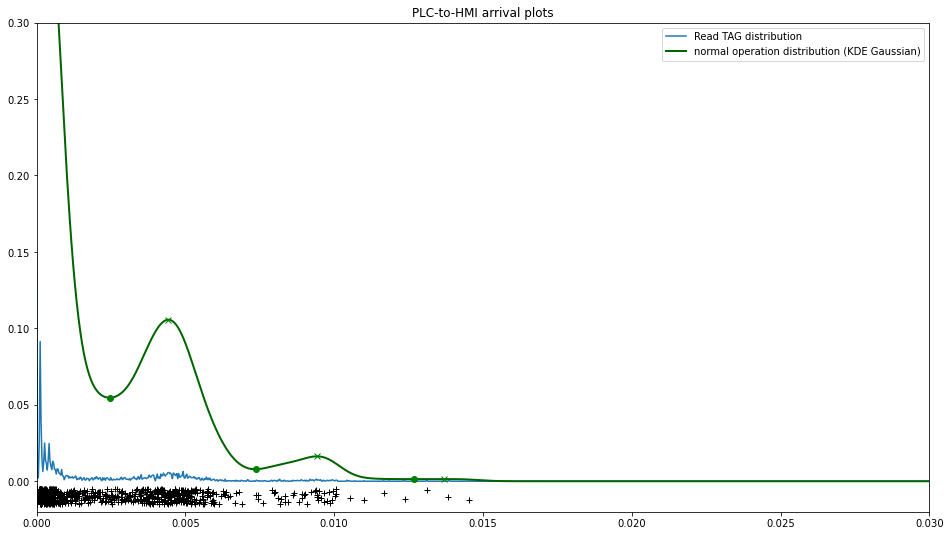

In [28]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

maxrange = 0.03
N = 1000
np.random.seed(1)
X = hmi_diff[:1000].reshape(-1,1)
X_plot = np.linspace(-0.0, maxrange, N)[:, np.newaxis]
hist, bin_edges = np.histogram(hmi_diff[:3000], bins=N, range=(0.0,maxrange), density=True)
bin_edges = bin_edges[:-1]
true_dens = hist[:]*maxrange*(1/N)
print(np.sum(true_dens))

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(X_plot[:, 0], true_dens,label='Read TAG distribution')

kde = KernelDensity(kernel='gaussian', bandwidth=0.0005).fit(X)
log_dens = kde.score_samples(X_plot)
dens = np.exp(log_dens)/1000
peaks, _ = find_peaks(dens, height=0.001)

valleys, _ = find_peaks(1-dens, height=0.001)


ax.plot(X_plot[:, 0], dens, color='darkgreen', lw=2,
        linestyle='-', label='normal operation distribution (KDE Gaussian)')
ax.plot(X_plot[peaks],dens[peaks], "gx")
ax.plot(X_plot[valleys],dens[valleys], "go")

#stack position and values
nppeaks = np.hstack((X_plot[peaks],dens[peaks].reshape(-1,1)))
npvalleys = np.hstack((X_plot[valleys],dens[valleys].reshape(-1,1)))
print("normal peaks",nppeaks)
print("normal valleys",npvalleys)
np.save("np_peaks.npy",nppeaks)
np.save("np_valleys.npy",npvalleys)

ax.title.set_text("PLC-to-HMI arrival plots")
ax.legend(loc='upper right')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-0.0, maxrange)
ax.set_ylim(-0.02, 0.3)

s = X_plot[:, 0]
e = np.exp(log_dens)/1000
a = X
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])